<a href="https://colab.research.google.com/github/hyehyunseo/ESAA_OB/blob/main/0918_%ED%95%B8%EC%A6%88%EC%98%A8_7%EC%9E%A5_%EC%95%99%EC%83%81%EB%B8%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[개념 정리]**
**9/18(월) 과제 - 핸즈온 7장 앙상블 학습과 랜덤 포레스트 p. 245-271**

---


# **CH7. 앙상블 학습과 랜덤포레스트**

* 앙상블학습 : 일련의 예측기로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있음

* 랜덤 포레스트 : 결정트리의 앙상블, 가장 강력한 머신러닝 알고리즘 중 하나

## **1. 투표 기반 분류기**

1. 직접 투표 분류기
    * 다수결 투표로 정해지는 분류기

    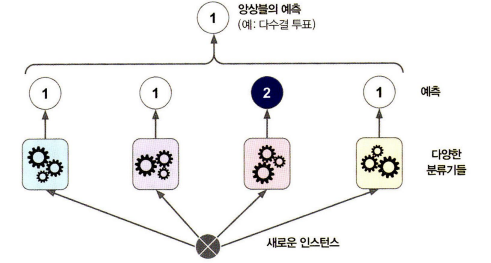

    * 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다 정확도가 높은 경우가 많다.

    * 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 강한 학습기가 될 수 있다.

* 앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 각기 다른 알고리즘으로 학습시키는 것이다.

    => 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.



2. 간접 투표 분류기
    * 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측
    * 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [3]:
# 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기를 만들고 훈련시키기
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)], voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [4]:
#  각 분류기의 테스트 셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred=clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.95
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


=> 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높다.

## **2. 배깅과 페이스팅**

1. 배깅
    * 훈련 세트에서 중복을 허용하여 샘플링하는 방식

2. 페이스팅
    * 훈련 세트에서 중복을 허용하지 않고 샘플링 하는 방식

=> 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있다. 하지만 배깅만이 한 예측기를 위해 같은 훈련 샘플을 여러 번 샘플링할 수 있다.

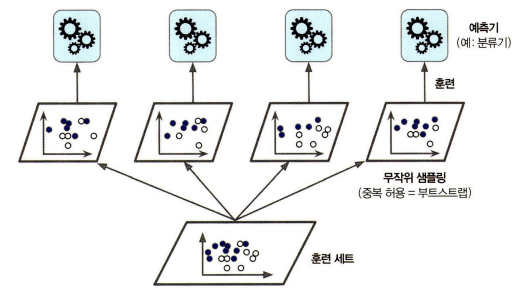

* 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.
    * 수집 함수는 분류일 때는 통계적 최빈값
    * 회귀일 때는 평균을 계산한다.
* 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 잇지만 수집 함수를 통과하면 편향과 분산이 모두 감소한다.

### **1) 사이킷런의 배깅과 페이스팅**

* 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드

In [6]:
# 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됨
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

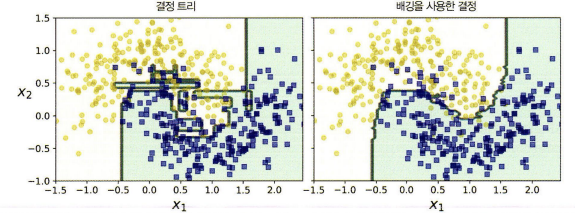

=> 위 그림은 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것이다.

=> 여기서 볼 수 있듯이 앙상블의 예측이 결정 트리 하나의 예측보다 일반화가 훨씬 잘 되어 있다. 앙상블은 비슷한 편향에서 더 작은 분산을 만든다.

* 부트 스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.
* 하지만 다양성을 추가한다는 것은 예측기들의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다.

### **2) oob 평가**

* oob 샘플 : 선택되지 않은 훈련 샘플의 나머지
* 예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 사용하지 않고 oob 샘플을 사용해 평가할 수 있다. 앙상블의 평가는 각 예측기의 obb 평가를 평균하여 얻는다.

In [11]:
# obb 평가
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8875

=> oob 평가 결과를 보면 위 모델은 테스트 세트에서 약 90%의 정확도를 얻을 것으로 보인다.

In [12]:
# 테스트 세트에서의 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

In [13]:
# obb 샘플에 대한 결정 함수의 값 확인
bag_clf.oob_decision_function_

array([[0.01923077, 0.98076923],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.98170732, 0.01829268],
       [0.0952381 , 0.9047619 ],
       [0.82      , 0.18      ],
       [0.02427184, 0.97572816],
       [0.10526316, 0.89473684],
       [0.7816092 , 0.2183908 ],
       [1.        , 0.        ],
       [0.62234043, 0.37765957],
       [0.        , 1.        ],
       [0.97727273, 0.02272727],
       [0.97837838, 0.02162162],
       [0.73076923, 0.26923077],
       [0.98333333, 0.01666667],
       [0.        , 1.        ],
       [0.98333333, 0.01666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.09047619, 0.90952381],
       [0.17204301, 0.82795699],
       [1.        , 0.        ],
       [0.04188482, 0.95811518],
       [0.98963731, 0.01036269],
       [0.98876404, 0.01123596],
       [0.01069519, 0.98930481],
       [0.64215686, 0.35784314],
       [0.98907104, 0.01092896],
       [0.

## **3. 랜덤 패치와 랜덤 서브스페이스**

* 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것
* 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것

=> 특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춘다.

## **4. 랜덤 포레스트**

* 500개 트리로 이뤄진 랜덤포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드

In [14]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [15]:
# BaggingClassifier를 사용해 RandomforestClassifier와 비슷하게 구현
bag_clf=BaggingClassifier(DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
                          n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

### **1) 엑스트라 트리**

* 극단적으로 무작위한 트리의 랜덤 포레스트를 익스트림 랜덤 트리, 엑스트라 트리라고 부른다.
* 여기서도 역시 편향이 늘어나지만 대신 분산을 낮추게 된다.
* 모든 노드에서 특성마다 가장 최적의 임곗값을 찾는 것이 트리 알고리즘에서 가장 시간이 많이 소요되는 작업 중 하나이므로 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.

### **2) 특성 중요도**

* 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.


In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09174508457270192
sepal width (cm) 0.022902388120563957
petal length (cm) 0.42432725385778475
petal width (cm) 0.4610252734489494


=> 가장 중요한 특성은 꽃잎의길이와 너비이며, 꽃받침의 길이와 너비는 비교적 덜 중요해보인다.

## **5. 부스팅**

1. 부스팅
    * 부스팅은 약한 학습기 여러 개를 연결하여 강한 학습기를 만드는 앙상블 방법
    * 부스팅 방법의 아이디어는 앞의 모델을 보완해나가면서 일련의 예측기를 학습시키는 것
    * 에이다부스트, 그레디언트 부스팅이 있음

### **1) 에이다부스트**

* 이전 예측기를 보완하는 새로운 예측기를 만드는 방법은 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높이는 것이다. 이렇게 하면 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 된다. 이 방식을 에이다부스트에서 사용함

* 알고리즘이 기반이 되는 첫번째 분류기를 훈련 세트에서 훈련시키고 예측을 만듦 => 그 다음 알고리즘이 잘못 분류된 훈련 샘플의 가중치를 상대적으로 높임 => 두번째 분류기는 업데이트된 가중치를 사용해 훈련 세트에서 훈련하고 다시 예측을 만듦

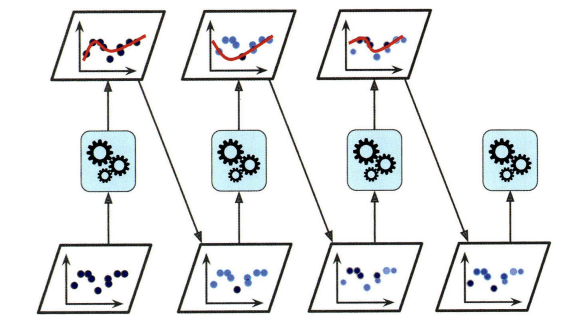

예시)

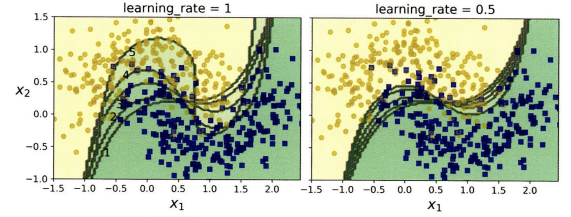

* 에이다부스트 알고리즘의 가중치가 적용된 에러율

    * 예측기가 정확할수록 가중치가 높아진다. 만약 무작위로 예측하는 정도라면 가중치가 0에 가깝다.
    
    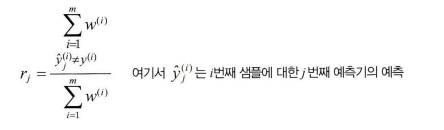

* 예측기 가중치와 가중치 업데이트 규칙

    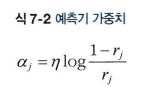

    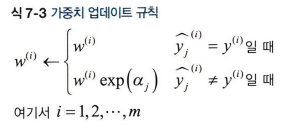


* 에이다부스트의 예측

    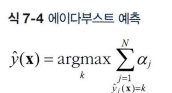

In [17]:
# AdaBoostClassifier의 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

### **2) 그레디언트 부스팅**

* 그레디언트 부스팅 : 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 방법
* 그레디언트 트리 부스팅 / 그레디언트 부스티드 회귀 트리

In [18]:
from sklearn.tree import DecisionTreeRegressor
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [19]:
# 첫번째 예측기에서 생긴 잔여 오차에 두번째 DT를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=1)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=1)

In [20]:
# 두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델을 훈련
y3 = y - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [21]:
# 새로운 샘플에 대한 예측 만들기
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

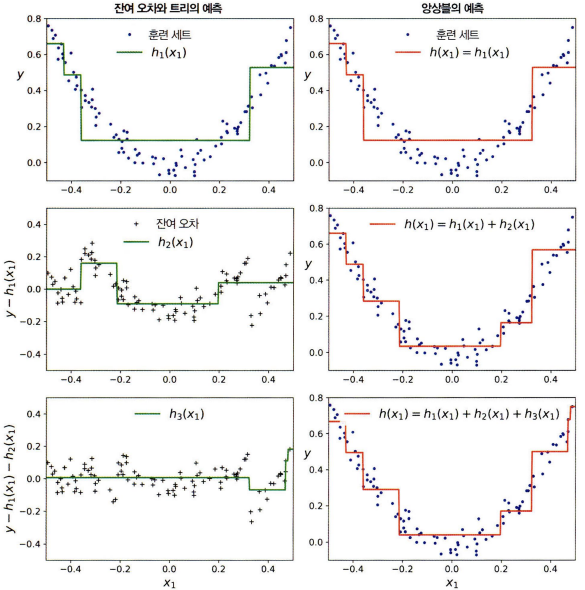

=> 왼쪽 열은 이 세 트리의 예측이고, 오른쪽 열은 앙상블의 예측이다. 첫번째 행에서는 앙상블에 트리가 하나만 있어서 첫번째 트리의 예측과 완전히 같다. 두번째 행에서는 새로운 트리가 첫번째 트리의 잔여 오차에 대해 학습되었다. 세번째 행에서는 또 다른 트리가 두번째 트리의 잔여 오차에 훈련되었다.

=> 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

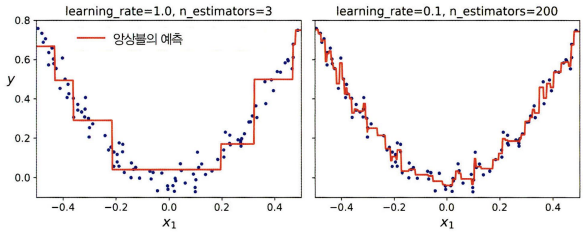

=> learning_rate 매개변수가 각 트리의 기여 정도를 조절한다. 이를 0.1처럼 낮게 설정하면 앙상블을 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 일반적으로 예측의 성능은 좋아진다.

=> 이는 축소라고 부르는 규제 방법이다.

* 최적의 트리 수를 찾기 위한 방법

In [23]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=1)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=1)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=119, random_state=1)

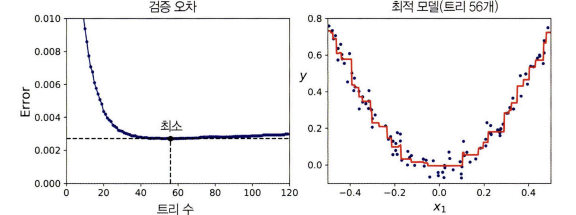

In [24]:
# 다섯번동안 검증 오차가 향상되지 않으면 훈련 멈춤
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=1)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

* GradientBoostingRegressor는 각 트리가 훈련할 때 사용할 훈련 샘플의 비율을 지정할 수 있는 subsample 매개 변수도 지원한다.
* 편향이 높아지는 대신 분산이 낮아지게 되고 훈련 속도를 상당히 높인다. 이런 기법을 확률적 그레디언트 부스팅이라고 한다.

In [25]:
import xgboost

xgb_reg = xgboost.XGBRegressor(random_state=1)
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [26]:
# 조기종료 기능
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41985
[1]	validation_0-rmse:0.34984
[2]	validation_0-rmse:0.31781
[3]	validation_0-rmse:0.30315
[4]	validation_0-rmse:0.29861
[5]	validation_0-rmse:0.28957
[6]	validation_0-rmse:0.28117
[7]	validation_0-rmse:0.27813
[8]	validation_0-rmse:0.27377
[9]	validation_0-rmse:0.27064
[10]	validation_0-rmse:0.26868
[11]	validation_0-rmse:0.26748
[12]	validation_0-rmse:0.26675
[13]	validation_0-rmse:0.26621
[14]	validation_0-rmse:0.26563
[15]	validation_0-rmse:0.26511
[16]	validation_0-rmse:0.26503
[17]	validation_0-rmse:0.26506


## **6. 스태킹**


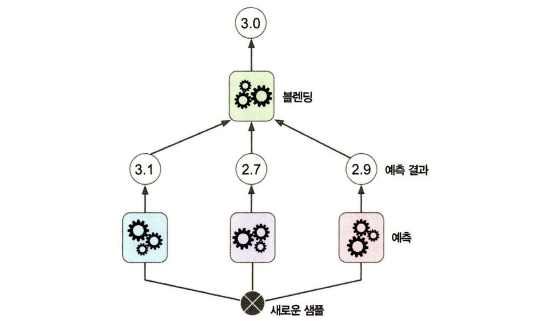

* 위 그림은 새로운 샘플에 회귀 작업을 수행하는 앙상블을 보여준다. 세 예측기는 각각 다른 값을 예측하고 마지막 예측기(= 블렌더)가 이 예측을 입력으로 받아 최종 예측을 만든다.

* 블렌더를 학습시키는 일반적인 방법은 홀드 아웃 세트를 사용하는 것이다.

1. 훈련 세트를 두개의 서브셋으로 나눈다. 첫번째 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용된다.

2. 첫번째 레이어의 예측기를 사용해 두번째 세트에 대한 예측을 만든다. 예측기들이 훈련하는 동안 이 샘플들을 전혀보지 못했기 때문에 이때 만들어진 예측은 완전히 새로운 것이다.

3. 홀드아웃 세트의 각 샘플에 대해 세 개의 예측값이 있다. 타깃값은 그대로 쓰고 앞에서 예측한 값을 입력 특성으로 사용하는 새로운 훈련 세트를 만들 수 있다.

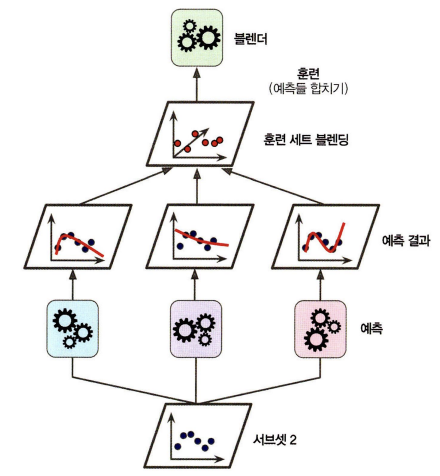